In [ ]:
!pip install Cython


In [46]:
import os
import time
import copy
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from IPython.display import Image as ig
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import datasets, transforms


In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [48]:
data_path = './dataset/mnist-digit/'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(1),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [49]:
BATCH_SIZE = 64

# EPOCHS = 10

In [50]:
#load dataset and apply dataloaders
image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_path, x),transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'val']}

In [51]:
target = image_datasets['train'].classes

In [52]:
dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes['val']

508

In [53]:
# print('==> Computing mean and std..')
# means, stds = 0, 0
# for i, (inputs, _labels) in enumerate(tqdm(dataloaders['train'])):
#     if i!=10:
#         means += inputs.mean()
#         stds += inputs.std()
# means.div_(dataset_sizes['train'])
# stds.div_(dataset_sizes['train'])
# # print(means, stds)

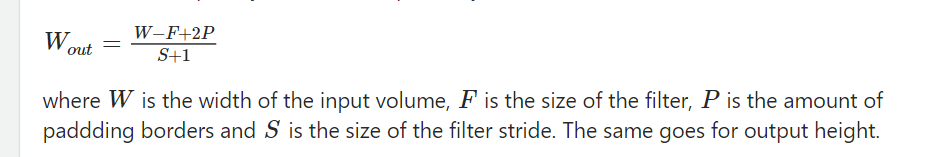

In [54]:
def check_size(w, f, p, s):
    wo = ((w-f+2*p)/(s+1))
    return wo

print(check_size(12, 2, 0, 1))
#46 #44
#40 #18
#14 #61

#26 #25
#12 #11


5.0


### Model

In [55]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)                                  
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2)                               
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)                                  
        self.fc1 = nn.Linear(8*11*11, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(dim=1)
#         softmax

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))         # output: 26*26 -> # output: 25*25
        x = self.pool2(self.relu(self.conv2(x)))         # output:  12*12 -> 11*11
        x = x.view(x.size(0), -1)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Model()

### Building Methods to train model and test on images.

In [56]:
class Methods:
    def __init__(self):
#         pass
        self.model = None
        
    def train(self, model, epochs, optimizer, criterion):
        self.model = model
        start = time.time()
    #     model_params = copy.deepcopy(model.state_dict())
        for epoch in (range(epochs)):  # loop over the dataset multiple times
            
            print(f'Epoch: {epoch+1}')
            for mode in ['train', 'val']:
#                 model.eval()
                running_loss = 0.0
                running_acc = 0.0
                for i, data in tqdm(enumerate(dataloaders[mode], 0), total=657):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    #transfer the inputs, labels to GPU 
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    inputs = inputs.float()
                    # zero the parameter gradients every mini batches
                    optimizer.zero_grad()
                    # forward pass
                    outputs = self.model(inputs)
                    #loss calculation
                    loss = criterion(outputs, labels)
#                     print(i, outputs.shape)
                    if mode=='train':
                        #backward pass
                        loss.backward()
                        #optimize and update the params
                        optimizer.step()

                    # print statistics
                    running_loss += loss.item()
                    #for ACcuracy
                    outputs = torch.log_softmax(outputs, dim=1)
                    max_vals, max_idx = torch.max(outputs, 1)
        #             max_idx = torch.argmax(outputs, 1)
                    check = torch.sum(max_idx==labels)
                    running_acc += check
        #         model_params = copy.deepcopy(model.state_dict())
                if mode=='train':
                    print(f'Training Loss: {running_loss:.3f} Training Accuracy: {(100*running_acc/dataset_sizes[mode]):.2f}%')
                else:
                    print(f'Validation Loss: {running_loss:.3f} Valaidation Accuracy: {(100*running_acc/dataset_sizes[mode]):.2f}%')
            print(f'-----------------------------------')
        end = time.time()
        training_time = end-start
    #     model.load_state_dict(model_params)
        print(f'Training Completed in: {training_time//60} min {training_time%60:.2f} sec')
        print('Finished Training')
        return self.model
    
    #test single image
    def testImage(self, PATH):
        if self.model==None:
            print('First, train the model.')
            return
        self.model.eval()
        image = Image.open(PATH)
        # Define a transform to convert the image to tensor
        transform = transforms.ToTensor()
        # Convert the image to PyTorch tensor
        img_tensor = transform(image)
        #adding one dimension [1*1*28*28]
        img_tensor = torch.unsqueeze(img_tensor, 0)
        #moved to GPU
        self.model.to(device)
        #moved to Tensor and GPU
        img_tensor = img_tensor.to(device)
        img_tensor = img_tensor.float()
        pred = trained_model(img_tensor)
        #aplying softmax
        check = F.softmax(pred, dim=1)
        #get maximum index value
        idx = torch.argmax(check, dim=1)
        return idx

### Loss and Optimizer


In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train  and Test

In [58]:
EPOCHS = 10
method = Methods()


In [36]:
trained_model = method.train(net.to(device), EPOCHS, optimizer, criterion)

Epoch: 1


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 177.144 Training Accuracy: 91.49%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 2.251 Valaidation Accuracy: 90.35%
-----------------------------------
Epoch: 2


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 171.827 Training Accuracy: 91.63%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.958 Valaidation Accuracy: 92.32%
-----------------------------------
Epoch: 3


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 164.410 Training Accuracy: 92.06%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.820 Valaidation Accuracy: 93.31%
-----------------------------------
Epoch: 4


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 156.657 Training Accuracy: 92.47%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 2.221 Valaidation Accuracy: 92.13%
-----------------------------------
Epoch: 5


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 151.701 Training Accuracy: 92.73%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.852 Valaidation Accuracy: 92.91%
-----------------------------------
Epoch: 6


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 147.036 Training Accuracy: 92.81%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.834 Valaidation Accuracy: 93.11%
-----------------------------------
Epoch: 7


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 139.457 Training Accuracy: 93.18%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.785 Valaidation Accuracy: 92.72%
-----------------------------------
Epoch: 8


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 133.781 Training Accuracy: 93.48%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.882 Valaidation Accuracy: 92.13%
-----------------------------------
Epoch: 9


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 128.944 Training Accuracy: 93.75%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.754 Valaidation Accuracy: 92.91%
-----------------------------------
Epoch: 10


  0%|          | 0/657 [00:00<?, ?it/s]

Training Loss: 122.747 Training Accuracy: 94.06%


  0%|          | 0/657 [00:00<?, ?it/s]

Validation Loss: 1.663 Valaidation Accuracy: 94.09%
-----------------------------------
Training Completed in: 4.0 min 7.98 sec
Finished Training


### Testing Single Image


In [78]:
# PATH = 'dataset/mnist-digit/test/img_28.jpg'
IMG_PATH = 'eight.png'
print(method.testImage(PATH))

First, train the model.
None


In [79]:
ig(filename=PATH)


### Save Model 

In [39]:
FILE_PATH = 'cnn_image_classification.pt'
torch.save(trained_model.state_dict(), FILE_PATH)


### Load Model

In [62]:
#restore/load model
# FILE_PATH = 'cnn_image_classification.pt'
net.load_state_dict(torch.load(FILE_PATH))
net.eval()


Model(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=968, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [86]:
def testImage2(model, PATH):
    image = Image.open(PATH)
    model = model.to(device)
    # Define a transform to convert the image to tensor
    transform = transforms.ToTensor()
    # Convert the image to PyTorch tensor
    img_tensor = transform(image)
    #adding one dimension [1*1*28*28]
    img_tensor = torch.unsqueeze(img_tensor, 0)
    #moved to GPU
    model.to(device)
    #moved to Tensor and GPU
    img_tensor = img_tensor.to(device)
    img_tensor = img_tensor.float()
    pred = model(img_tensor)
    #aplying softmax
    check = F.softmax(pred, dim=1)
    #get maximum index value
    idx = torch.argmax(check, dim=1)
    
    return target[idx]

In [87]:
IMG_PATH = 'dataset/mnist-digit/test/img_1.jpg'
testImage2(net, IMG_PATH)

'2'

In [88]:
ig(filename=IMG_PATH)